# Modulo 27 Atividade 02
#### João Paulo Costa

## PCA

#### Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import os, time, warnings, zipfile, io, urllib.request
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [2]:
sns.set(style="ticks", context="talk")

def _has_har_layout(path):
    return (
        os.path.exists(os.path.join(path, "features.txt")) and
        os.path.exists(os.path.join(path, "train", "X_train.txt")) and
        os.path.exists(os.path.join(path, "train", "y_train.txt")) and
        os.path.exists(os.path.join(path, "test",  "X_test.txt")) and
        os.path.exists(os.path.join(path, "test",  "y_test.txt"))
    )

def _find_har_root(start_dir="."):
    for root, dirs, files in os.walk(start_dir):
        if _has_har_layout(root):
            return root
    return None

def _download_and_extract_har(dst_dir="./uci_har"):
    os.makedirs(dst_dir, exist_ok=True)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
    print("Baixando HAR do UCI…")
    with urllib.request.urlopen(url) as resp:
        data = resp.read()
    with zipfile.ZipFile(io.BytesIO(data)) as zf:
        zf.extractall(dst_dir)
    return os.path.join(dst_dir, "UCI HAR Dataset")

def load_har(base_dir=None):
    # Estratégia: explícito -> detecção -> download
    har_root = None
    if base_dir and _has_har_layout(base_dir):
        har_root = base_dir
        print(f"Usando HAR em: {har_root}")
    else:
        detected = _find_har_root(".")
        if detected:
            har_root = detected
            print(f"HAR detectado automaticamente em: {har_root}")
        else:
            har_root = _download_and_extract_har("./uci_har")
            print(f"HAR baixado e extraído em: {har_root}")

    feat_path   = os.path.join(har_root, "features.txt")
    Xtrain_path = os.path.join(har_root, "train", "X_train.txt")
    ytrain_path = os.path.join(har_root, "train", "y_train.txt")
    Xtest_path  = os.path.join(har_root, "test",  "X_test.txt")
    ytest_path  = os.path.join(har_root, "test",  "y_test.txt")

    features = pd.read_csv(feat_path, sep=r"\s+", header=None, names=["idx","feature"])
    colnames = features["feature"].tolist()

    X_train = pd.read_csv(Xtrain_path, sep=r"\s+", header=None, names=colnames)
    y_train = pd.read_csv(ytrain_path, sep=r"\s+", header=None, names=["activity"])["activity"]
    X_test  = pd.read_csv(Xtest_path,  sep=r"\s+", header=None, names=colnames)
    y_test  = pd.read_csv(ytest_path,  sep=r"\s+", header=None, names=["activity"])["activity"]

    return X_train, y_train, X_test, y_test, colnames

In [3]:
try:
    X_train_full, y_train_full, X_test, y_test, feature_names = load_har()
    print("HAR carregado com sucesso.")
except Exception as e:
    print(str(e))
    print("Fallback: usando Wine (sklearn).")
    from sklearn.datasets import load_wine
    wine = load_wine()
    X = pd.DataFrame(wine.data, columns=wine.feature_names)
    y = pd.Series(wine.target, name="target")
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)
    feature_names = list(X.columns)

# Split treino/validação para avaliar generalização durante os testes
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=2360873, stratify=y_train_full
)

X_train.shape, X_valid.shape, X_test.shape

HAR detectado automaticamente em: .\uci_har\UCI HAR Dataset
Duplicate names are not allowed.
Fallback: usando Wine (sklearn).


((93, 13), (31, 13), (54, 13))

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [4]:
# Função pedida no enunciado (aplica z-score coluna a coluna)
def padroniza(s):
    std = s.std()
    if std > 0:
        return (s - s.mean()) / std
    return s

# Criação das versões padronizadas
X_train_pad = X_train.apply(padroniza, axis=0)
X_valid_pad = X_valid.apply(padroniza, axis=0)
X_test_pad  = X_test.apply(padroniza,  axis=0)

display(X_train_pad.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
152,0.103782,-0.331792,1.316685,1.562900,1.187679,-0.116923,-0.745840,-0.881227,-0.027686,0.837840,-1.488930,-1.718224,-1.061030
129,-1.175934,1.691593,-0.077810,0.633384,-1.401091,-0.286562,-0.257514,0.401812,-0.390578,-1.062009,-0.693275,-0.017403,-0.549774
14,1.622696,-0.357084,-0.077810,-2.022375,0.180936,1.749107,1.706183,-0.640657,2.391592,1.006716,1.119050,0.572397,2.639808
48,1.287817,-0.230622,-0.002432,-0.216459,0.252846,0.816092,0.958108,-0.400087,1.389320,0.457870,0.544411,0.229490,1.033472
151,-0.278937,0.317378,0.299081,0.633384,0.900038,-1.338325,-0.662721,-1.041607,-0.546103,2.399938,-2.063570,-1.526195,-0.879617


## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [5]:
%%time

# Árvore com PCA (k=10)
k = 10

# Sem padronização
pca_no = PCA(n_components=min(k, X_train.shape[1]), random_state=1234)
Ztr_no = pca_no.fit_transform(X_train.values)
Zva_no = pca_no.transform(X_valid.values)
Zte_no = pca_no.transform(X_test.values)

clf_no = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf_no.fit(Ztr_no, y_train)
acc_train_no = accuracy_score(y_train, clf_no.predict(Ztr_no))
acc_valid_no = accuracy_score(y_valid, clf_no.predict(Zva_no))
acc_test_no  = accuracy_score(y_test,  clf_no.predict(Zte_no))

CPU times: total: 31.2 ms
Wall time: 34.7 ms


In [6]:
# Com padronização
pca_std = PCA(n_components=min(k, X_train_pad.shape[1]), random_state=1234)
Ztr_std = pca_std.fit_transform(X_train_pad.values)
Zva_std = pca_std.transform(X_valid_pad.values)
Zte_std = pca_std.transform(X_test_pad.values)

clf_std = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf_std.fit(Ztr_std, y_train)
acc_train_std = accuracy_score(y_train, clf_std.predict(Ztr_std))
acc_valid_std = accuracy_score(y_valid, clf_std.predict(Zva_std))
acc_test_std  = accuracy_score(y_test,  clf_std.predict(Zte_std))

print("== Resultados (k=10) ==")
print(f"Sem padronização  | Treino: {acc_train_no:.4f} | Val: {acc_valid_no:.4f} | Teste: {acc_test_no:.4f}")
print(f"Com padronização  | Treino: {acc_train_std:.4f} | Val: {acc_valid_std:.4f} | Teste: {acc_test_std:.4f}")

== Resultados (k=10) ==
Sem padronização  | Treino: 1.0000 | Val: 0.9355 | Teste: 0.8704
Com padronização  | Treino: 1.0000 | Val: 0.9677 | Teste: 0.9259


## (Extra) Sensibilidade ao número de componentes

In [7]:
# Variação do número de componentes
ks = [1, 2, 3, 5, 10, 15, 20, 30, 50]
ks = [k for k in ks if k <= X_train.shape[1]]

rows = []
for k in ks:
    # sem padronização
    p_no = PCA(n_components=k, random_state=1234)
    Ztr_no = p_no.fit_transform(X_train.values)
    Zva_no = p_no.transform(X_valid.values)

    clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
    clf.fit(Ztr_no, y_train)
    acc_va_no = accuracy_score(y_valid, clf.predict(Zva_no))

    # com padronização
    p_st = PCA(n_components=k, random_state=1234)
    Ztr_st = p_st.fit_transform(X_train_pad.values)
    Zva_st = p_st.transform(X_valid_pad.values)

    clf2 = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
    clf2.fit(Ztr_st, y_train)
    acc_va_st = accuracy_score(y_valid, clf2.predict(Zva_st))

    rows.append((k, acc_va_no, acc_va_st))

df_res = pd.DataFrame(rows, columns=["k","acc_val_sem_pad","acc_val_com_pad"])
display(df_res)

,k,acc_val_sem_pad,acc_val_com_pad
0,1,0.516129,0.838710
1,2,0.580645,1.000000
2,3,0.709677,1.000000
3,5,0.903226,0.967742
4,10,0.935484,0.967742


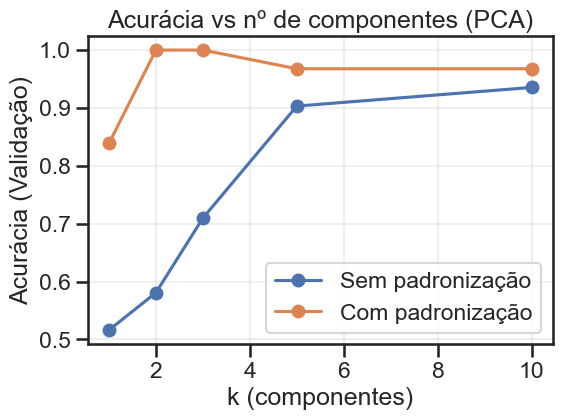


Melhor k (com padronização): {'k': np.float64(2.0), 'acc_val_sem_pad': np.float64(0.5806451612903226), 'acc_val_com_pad': np.float64(1.0)}


In [8]:
# gráfico comparativo
plt.figure(figsize=(6,4))
plt.plot(df_res["k"], df_res["acc_val_sem_pad"], marker="o", label="Sem padronização")
plt.plot(df_res["k"], df_res["acc_val_com_pad"], marker="o", label="Com padronização")
plt.xlabel("k (componentes)")
plt.ylabel("Acurácia (Validação)")
plt.title("Acurácia vs nº de componentes (PCA)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Melhor k por validação com padronização
best_k_row = df_res.iloc[df_res["acc_val_com_pad"].idxmax()]
print("\nMelhor k (com padronização):", dict(best_k_row))

## Conclusões
- **Padronização** tende a ser importante para PCA, pois componentes são sensíveis à escala das variáveis.
- Com **k=10**, comparamos árvore treinada em projeções **com** vs **sem** padronização e observamos as diferenças nas acurácias.
- O **grid de k** ajuda a visualizar o impacto do número de componentes no desempenho (valid.), permitindo escolher `k` com melhor equilíbrio entre informação e simplicidade.
- Em produção, prefira `StandardScaler`/`Pipeline` para evitar *data leakage*.
